## Loading Models Demo

This is a demo for how to load and use serialized models from a directory.  

Run a model in the `./training_scripts` directory, then use this demo. Here we assume you ran the `ae2D.sh` 

In [2]:
import os
from integrated_cell import utils

#If you need to, use this to change the GPU with which to load a model
gpu_ids = [0]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])

#Specify the model directory to use
model_dir = "./training_scripts/cbvae2D/"

#Load the model. These variables shouldn't change as a function of model type
networks, data_provider, args = utils.load_network_from_dir(model_dir)

encoder = networks['enc'].cuda()
decoder = networks['dec'].cuda()

encoder.train(False)
decoder.train(False)

#If you're not clear on how to use the network, then the best thing to do is to training model and check out how it is used:
f"integrated_cell/models/{args['train_module']}.py"

loading from /allen/aics/modeling/gregj/projects/pytorch_integrated_cell/examples/training_scripts/cbvae2D/ref_model/enc.pth
loading from /allen/aics/modeling/gregj/projects/pytorch_integrated_cell/examples/training_scripts/cbvae2D/ref_model/dec.pth


'integrated_cell/models/cbvae2_target.py'

asdf


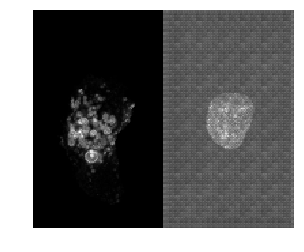

In [3]:
from integrated_cell.utils.plots import imshow
import integrated_cell.utils as utils
import torch 
import matplotlib
%matplotlib inline

x, class_labels, ref = data_provider.get_sample('test', [0])

x = x.cuda()
class_labels = class_labels.cuda().long()
class_labels_onehot = utils.index_to_onehot(class_labels, data_provider.get_n_classes())
ref = ref.cuda()

# Typical autoencoder
if args['train_module'] == 'ae':
    
    # z is the latent representation of the image x
    z = encoder(x)
    xHat = decoder(z)
    
elif args['train_module'] == 'bvae':

    # z is the latent representation of the image x
    z_mu, z_sigma = encoder(x)
    
    # here we can either the "average" by passing z_mu into the decoder or
    # we can resample from N(z_mu, z_sigma)
    z_sampled = utils.reparameterize(z_mu, z_sigma)
    xHat = decoder(z_sampled)
    
elif args['train_module'] in ['cbvae2_target', 'cbvaegan_target2', 'cbvaegan_target']:
    # These are the conditional models: We provide the class labels and reference structures to both the encoder and decoder
    # and the model (hopefully) doesn't 
    
    # z is the latent representation of the image x
    z_mu, z_sigma = encoder(x, ref, class_labels_onehot)
    
    # here we can either the "average" by passing z_mu into the decoder or
    # we can resample from N(z_mu, z_sigma)
    z_sampled = utils.reparameterize(z_mu, z_sigma)
    
    xHat = decoder(z_sampled, ref, class_labels_onehot)
    
im_out = torch.cat([x, xHat], axis = 3)
imshow(im_out)
